## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The goal of this project is to run through an A/B test and help an e-commerce website determine if they should implement their new web-page, keep their old one or perhaps run the experiment longer to make their decision. 

<a id='probability'></a>
#### Part I - Probability

The first part of this project is to run through some basic probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#The seed here is set to 42 to assure I get the same answers as the online quizzes set up on Udacity.com
random.seed(42)

`1.` We'll start by reading the ab test results and store the data in a dataframe df

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`2.` Next we will investigate the dataframe a little closer, looking at the number of rows, unique users and at the basic conversion numbers.

__Number of rows__, any missing values?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There are 294478 entries in the dataset. There are no missing values as well since all the columns have 294478 non-null entries

__The number of unique users in the dataset.__

In [5]:
df.user_id.nunique()

290584

__The proportion of users converted__

In [6]:
df.converted.mean()

0.11965919355605512

3. Now we want to make sure that the control group strictly received the old page and that the treatment group strictly received the new page.

__The number of times the `new_page` and `treatment` don't line up__

In [7]:
df.query('landing_page == "new_page" and group =="control"').count() + df.query('landing_page== "old_page" and group =="treatment"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

`3.` We have 3893 rows that don't line up. We want to remove those rows from the dataset because we cannot be sure where those entries belong and we want to avoid any mistakes in our analysis.

We will create a new dataframe __df2__ that does not contain these rows

In [8]:
experimental_group = df.query('landing_page =="new_page" and group == "treatment"')
control_group = df.query('landing_page =="old_page" and group =="control"')

df2= pd.concat([control_group, experimental_group])

The new DataFrame only contains the rows where the __control__ group is lined up with __old_page__ and the __treatment__ group is aligned with __new_page__

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]


0

`4.` Now that we have trimmed the initial dataset, we will run more checks on it.

Firstly I will check the amount of unique users using the column 'user_id'

Amount of unique **user_id**s in **df2**

In [10]:
df2.user_id.nunique(), len(df2)

(290584, 290585)

290584 unique users, and 290585 rows in total... 1 user is repeated in the dataset!!

There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id ==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


I will remove **one** of the rows with a duplicate **user_id** since that user did not convert in both instances 

In [13]:
df2.drop_duplicates(subset=['user_id'], inplace=True )

In [14]:
#Verifying that this worked out, the number should be 1 less then 290585
len(df2)

290584

`5.` Now we will look through **df2** and examine the conversion rates through there.

__What is the probability of an individual converting regardless of the page they receive?__

In [15]:
df2.converted.mean()

0.11959708724499628

__Given that an individual was in the `control` group, what is the probability they converted?__

In [16]:
control_converted = df2.query('group =="control"').converted.mean()
control_converted

0.1203863045004612

__Given that an individual was in the `treatment` group, what is the probability they converted?__

In [17]:
treatment_converted = df2.query('group =="treatment"').converted.mean()
treatment_converted

0.11880806551510564

__What is the probability that an individual received the new page?__

In [18]:
(df2.landing_page =="new_page").mean()

0.5000619442226688

In [19]:
difference = (treatment_converted - control_converted) * 100
difference

-0.15782389853555567

Considering our results above, I dont think there is significant evidence yet to determine that the new treatment page leads to more conversions. This is because the difference in conversion rates between the treatment group and the control group is very small (less then 1%, -0.15%, see above). We need to run more tests which are found below

<a id='ab_test'></a>
### Part II - A/B Test

To determine the statistical significance of our results we need to establish a Null and Alternative Hypothesis.

The null hypothesis that I have chosen here is that

__Null Hypothesis: **$p_{old}$** = **$p_{new}$**__

and Alternative Hypothesis is

__Alt. Hypothesis: **$p_{old}$** != **$p_{new}$**__

where  **$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages



In this section we are going to start off by assuming that **$p_{old}$** and **$p_{new}$** are equal and that they are equal to the conversion rate of the whole set. At this point, we are going to simulate 10,000 **$p_{new}$** - **$p_{old}$** transactions under the null and determine the p-value based on our observed difference. By calculating the difference in conversion 10,000 times,  this will help us determine if our statistic found in the A/B test emerged from our (imaginary) population where **$p_{old}$** = **$p_{new}$**  

Therefore, **$p_{old}$** = **$p_{new}$** 

In [20]:
p_new= df2.converted.mean()
p_new

0.11959708724499628

In [21]:
p_old= df2.converted.mean()
p_old

0.11959708724499628

$n_{new}$ and $n_{old}$ are calculated below

In [22]:
n_new= df2.query("landing_page =='new_page'").user_id.nunique()
n_old = df2.query("landing_page =='old_page'").user_id.nunique()
n_new, n_old

(145310, 145274)

Now we will simulate 10,000 $p_{new}$ - $p_{old}$ values and the results will be stored in a numpy array called **p_diffs**.

In [23]:
new_page_conversion = np.random.binomial(n_new, p_new,  10000)/n_new
old_page_conversion = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_page_conversion - old_page_conversion


Now we can plot a histogram of the **p_diffs** which is the difference in success rates between the New Page and the Old Page ran 10,000 times for n_new and n_old times.

Text(0, 0.5, 'Frequency')

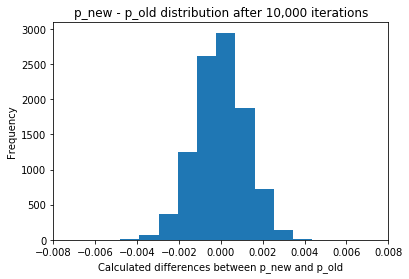

In [24]:
plt.title('p_new - p_old distribution after 10,000 iterations')
plt.hist(p_diffs)
plt.xlim(-0.008, 0.008)
plt.xlabel('Calculated differences between p_new and p_old')
plt.ylabel('Frequency')

After running the experiment 10,000 times, we can calculate the proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**, which is the actual test conducted

In [25]:
#the null hypothesis here was that p_new= p_old, therefore under the null the difference is 0
null_diff= 0

#for the observed difference we get
prob_new = df2.query('landing_page =="new_page"').converted.mean()
prob_old = df2.query('landing_page =="old_page"').converted.mean()

obs_diff = prob_new - prob_old
obs_diff

-0.0015782389853555567

In [26]:
(p_diffs > (prob_new -prob_old)).mean()

0.9048

Text(0, 0.5, 'Frequency')

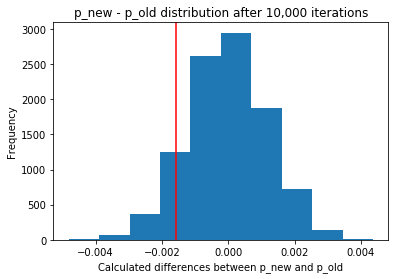

In [27]:
plt.hist(p_diffs)

boundary = obs_diff

plt.axvline(x=boundary, color = 'red'); # where our sample mean falls on null dist

plt.title('p_new - p_old distribution after 10,000 iterations')
plt.xlabel('Calculated differences between p_new and p_old')
plt.ylabel('Frequency')



In [28]:
p_diffs.mean(), p_diffs.std(), p_diffs.var()

(-1.2540689048525111e-05, 0.00119581442495122, 1.429972138921417e-06)

The p-value here is 0.9053 which is the area of all the blue blocks starting at and to the right of the red line.

90.73 % of the p_diffs values are greater than the actual difference observed in ab_data. This would actually be the p-value for the 1-sided test in which case our null would be that p_old - p_new >= 0  and our alt would be p_new - p_old >= 0 and with a p-value greater then 0.05 we would have to reject the Alt. Hypothesis and fail to reject the Null.

However, since we started out with the null of p_old = p_new and p_old != p_new I will conduct the two tailed test below 

##Two tailed test

In [29]:
# remember,  the null hypothesis here was that p_new = p_old
# since our alt hypothesis was that the difference != 0 then we need to conduct a 2 tail test

lower_bound  = (p_diffs <= (obs_diff)).mean()
#remember our observed differnce here was -0.0015782..

higher_bound = (p_diffs >= (null_diff - obs_diff)).mean()

pvalue = (lower_bound + higher_bound)

pvalue

0.1885

Again, since the p-value is higher then the standard error rate of 0.05, then we need to reject the alt hypothesis or fail to reject the null hypothesis of p_old = p_new and ultimately that there is no difference between the conversion rate of the new page and the old page.

Text(0, 0.5, 'Frequency')

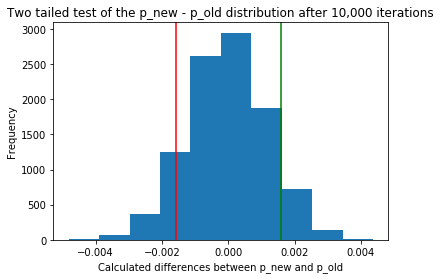

In [30]:
plt.hist(p_diffs)

lower_bound = obs_diff
higher_bound = null_diff - obs_diff

plt.axvline(x=lower_bound, color = 'red'); # where our sample mean falls on null dist
plt.axvline(x=higher_bound, color = 'green'); # where our sample mean falls on null dist

plt.title('Two tailed test of the p_new - p_old distribution after 10,000 iterations')
plt.xlabel('Calculated differences between p_new and p_old')
plt.ylabel('Frequency')


In other words, after simulating the experiment 10,000 times (10,000 is large enough, we can run this experiment one hundred thousand times or even a million times) assuming that p_new = p_old, we found that our __observed difference__ in our sample lies within the 95% boundaries of this distribution. We can deduce this because the Area to the Left of the Red Line <= + the area to the right of the green line >=  is our p-value of 0.1889. Or again, since the p-value is greater then 0.05 we can reject the alternative hypothesis that p_old != p_new and therefore fail to reject the null of p_old = p_new

## Lenght of the experiment

In [31]:
df4=df2.copy()
df4.sort_values(by='timestamp', inplace=True)
df4.iloc[0,1], df4.iloc[-1, 1], len(df4), n_old, n_new

('2017-01-02 13:42:05.378582',
 '2017-01-24 13:41:54.460509',
 290584,
 145274,
 145310)

## Duration of experiment:
As we can see, the experiment ran for 3 weeks and we collected over 290,000 results and entries. This is an appropriate duration because we were able to collect a lot of entries. Moreover, the proportion of users who visited each page is approximately 50% which means that we led an appropriate number of users to each page.

## Using the built-in stats libraries

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Below you will see how everything can be done using the built in statsmodel library.

In [32]:
import statsmodels.api as sm


convert_old = sum(df2.query('landing_page == "old_page"').converted)
convert_new = sum(df2.query('landing_page == "new_page"').converted)
n_old = df2.query('landing_page =="old_page"').shape[0]
n_new = df2.query('landing_page =="new_page"').shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
#now we calculate the zscore for the difference using proportions_ztest
# 1 sided test
zscore, pvalue = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller', prop_var = False)

zscore, pvalue

#null: p_old - p_new >=0
#alt:  p_new - p_old > 0


(1.3109241984234394, 0.9050583127590245)

In [34]:
# 2-sided test
zscore2, pvalue2 = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'two-sided', prop_var = False)

zscore2, pvalue2

(1.3109241984234394, 0.18988337448195103)

In [35]:
#Even using the Confidence intervall approach we can see that the result above of 1.31 lies within the 95% CI boundaries

#Assume a 95% CI
from scipy.stats import norm
left_boundary  = norm.ppf(0.05/2)
right_boundary = norm.ppf(1-(0.05/2))

#these are the standard z scores for a 95% CI
left_boundary, right_boundary

(-1.9599639845400545, 1.959963984540054)

The results here are identical to the ones found in the section where I drew the histograms. pvalue was 0.905 which is the 1-sided p-value and pvalue2 is 0.189 which was the result from the 2-sided test. 

<a id='regression'></a>
### Part III - A regression approach

We can also achieve similar results by utilizing the regression libraries

Since each row is either a conversion or no conversion, this would be a Logistic Regression problem. Linear or Multilinear regression models require variables that are continuous whereas in our case we have a Yes/No result.

The approach here is to use **statsmodels** to fit the regression model. We will start off by creating a column for the intercept and creating dummy variable columns for which page each user received. The dummy variable will be 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2['intercept'] = 1
df2[['ab_page_treatment','ab_page_control']] = pd.get_dummies(df2['landing_page'])

df2.sample(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page_treatment,ab_page_control
290544,919217,2017-01-14 11:27:25.844527,control,old_page,0,1,0,1
197282,859435,2017-01-05 18:52:43.920475,treatment,new_page,0,1,1,0
223351,908648,2017-01-17 04:01:15.265318,treatment,new_page,0,1,1,0
152647,799543,2017-01-17 21:21:59.329216,treatment,new_page,0,1,1,0
205015,857899,2017-01-11 17:28:13.379287,treatment,new_page,0,1,1,0


Now we will import the regression model and look at the summary of the results

In [37]:
logm= sm.Logit(df2['converted'], df2[['intercept', 'ab_page_treatment']])
results = logm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 02 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        16:18:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page_treatment    -0.0150      0.011     -1.311      0.190      -0.037       0.007
=====================================================================================
"""

The important value here to look at is the p-value found in P>|z| for the ab_page_treatment row. 

In logistic regression, when we use dummy variables, we compare one result in relationship to the other. In this case we have ab_page_treatment which means ap_page_control is our baseline so the __difference__ each page has on the conversion ratio is insignificant. Since we are doing the __difference__ this implies that our Null is p_old = p_new or p_old - p_new = 0 and our Alt hypothesis is p_old != p_new or p_old - p_new <=0 Since our p-value here is larger then 0.05, we reject the alternative hypothesis or fail to reject the null that p_old = p_new and therefore the new landing page has no effect on the conversion ratio. This result is the same as the two-sided test that we previously conducted.


#### Is it a good idea to consider other factors that might influence whether or not an individual converts? What are the disadvantages to adding additional terms in a regression model?

It is a good idea to consider other factors because we do not have many independant variables so there can be other factors such as font size, web-page layout and where everything is located that can influence the conversion ratio.  However, we cannot add too many factors in our model because we may run into problems such as overfitting, multicollinearity, Simpson's Paradox and the Curse of dimensionality which will complicate the analysis. <br /> 
<br /> 
-Overfitting occurs when our model fits too closely with the given data set, the pitfall here is that the model may not be accurate at representing new data. <br /> -Multicollinearity occurs when our independant variables are correlated which disturbs our model, coefficients and reliability. <br /> -Simpson's paradox is a problem statisticians often run into when adding and aggregating too many variables. Relationships are often missed because the data is too aggreggated and different relationships and conclusions may appear depending on what biases and factors you look into. <br /> -Finally, the Curse of dimensionality is a problem statisticians face when adding too many variables and factors. Generally, the more variables we add, then the amount of data we need grows exponentially. In our case, this might mean running both landing pages for months to obtain an adequate amount of data.

The last part of this assignment was to import a table that contained where each user lived and see if users if there was an effect on the conversion ratio depending on where each user lived. The required user data is found in the countries.csv file 

Again, we will create dummy variables and run the same Logistic Regression Model

In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [39]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [40]:
### Create the necessary dummy variables
df_new[['Canada', 'UK', 'USA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page_treatment,ab_page_control,Canada,UK,USA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


Firstly, we will only consider the country's effect on the conversion ratio (so the fact that a user went to the new or old page isnt't considered here)

In [41]:
logm2 = sm.Logit(df_new['converted'], df_new[['intercept', 'Canada','UK']])
results2 = logm2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 02 Feb 2019   Pseudo R-squ.:               1.521e-05
Time:                        16:18:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
Canada        -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

Since all the p-values in column P>lzl  are bigger then 0.05 we know these factors are not statistically significant in determining whether or not a conversion occurs. 

The last step is to determine if there is an interaction between the country and the new page and old page. This is completed below.

In [42]:
df_new['Canada_treatment'] = df_new['Canada'] * df_new['ab_page_treatment']
df_new['UK_treatment']     = df_new['UK']     * df_new['ab_page_treatment']

In [43]:
### Fit Your Linear Model And Obtain the Results
logm3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page_treatment', 'Canada', 'UK', 'Canada_treatment', 'UK_treatment']])
results3= logm3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Feb 2019   Pseudo R-squ.:               3.482e-05
Time:                        16:18:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page_treatment    -0.0206      0.014     -1.505      0.132      -0.047       0.006
Canada               -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK                   -0.0057      0.019     -0.306      0.760      -0.043       0.031
Canada_treatment     -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_treatment          0.0314      0.027      1.181      0.238      -0.021       0.084
=====================================================================================
"""

Results: The associated p-values in the table above are all above 0.05 or 5% which means we fail to reject the null hypothesis and reject the alternative hypothesis that these factors affect the conversion rate. The null hypothesis is always a defensive one where 'the conversion rate of the old page is better or equal then the conversion rate of the new page and that the user_id's country does not have effect on the conversion rate. Since the p-values are so high, even with the interaction variables included, they are not statistically significant in helping us determine a relationship with the conversion rates.   

## Conclusions

In conclusion, we were able to look at and analyze the A/B test of an ecomerce website and we determined that there was no difference with the conversion rates between the new and old landing page. In addition, the test ran for 3 weeks and both landing pages had an equivalent number of visitors. We ran an A/B test and a Logistic regression to determine this and had identical conclusions. Finally, we tried to determine if the location where the user resides ('country') had an effect on the conversion rates of the old and new landing page but again we discovered that this parameter was not meaningful and did not have any interaction and any impact in our model. 

Ressources: The outline and enumerated questions were provided by udacity.com The format was kept to help the reader understand the order of the analysis. Other ressources are indicated below
- Two-sample Proportion Hypothesis Testing with Statsmodels http://knowledgetack.com/python/statsmodels/proportions_ztest/
- Simpson's Paradox:  https://www.youtube.com/watch?v=ebEkn-BiW5k
- Multicollinearity: www.statisticssolutions.com/multicollinearity/
- Curse of Dimensionality  https://www.youtube.com/watch?v=QZ0DtNFdDko